# 擬似相関チュートリアル Part 4: 非線形関係における擬似相関の判別

## チュートリアル全体の構成
1. [擬似相関とは & データの準備](01_spurious_correlation_intro.ipynb)
2. [SHAP による特徴量重要度分析](02_shap_analysis.ipynb)
3. [因果探索（LiNGAM）による構造推定](03_causal_discovery_lingam.ipynb)
4. **非線形関係における擬似相関の判別** (このノートブック)
5. [まとめと使い分けガイドライン](05_summary.ipynb)

---
## 共通セットアップ

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Meiryo'
matplotlib.rcParams['axes.unicode_minus'] = False

print('セットアップ完了')

セットアップ完了


---
## 7. 発展: 非線形関係における擬似相関の判別

ここまでの分析は **線形データ** を前提としていました。
しかし現実のデータでは変数間の関係が非線形であることが多いです。

### 問い
> 変数間の関係が非線形でも、擬似相関かどうかを判別できるか？

### 理論的背景

**条件付き独立性は DAG の性質であり、関数形に依存しない**:
- DAG 上で N4 が Y の子孫でなく、X を条件付けると d-分離される場合、
  `N4 ⊥ Y | X` は関数が線形でも非線形でも成立する
- つまり、適切な条件付き独立性検定を使えば、非線形でも擬似相関を判別可能

| 手法 | 線形 | 非線形 | 原理 |
|:---|:---:|:---:|:---|
| LiNGAM | ✓ | ✗ | 線形 + 非ガウスを仮定 |
| PC + Fisher-z | ✓ | ✗ | 線形相関ベースのCI検定 |
| PC + KCI | ✓ | ✓ | カーネル条件付き独立性検定 |

以下では、非線形データを生成し、各手法の性能を比較します。

=== 非線形データセット ===
サイズ: (800, 8)
直接原因: ['X', 'M', 'Z1', 'D1']
擬似相関: ['N1', 'N4']
独立ノイズ: [N_ind]


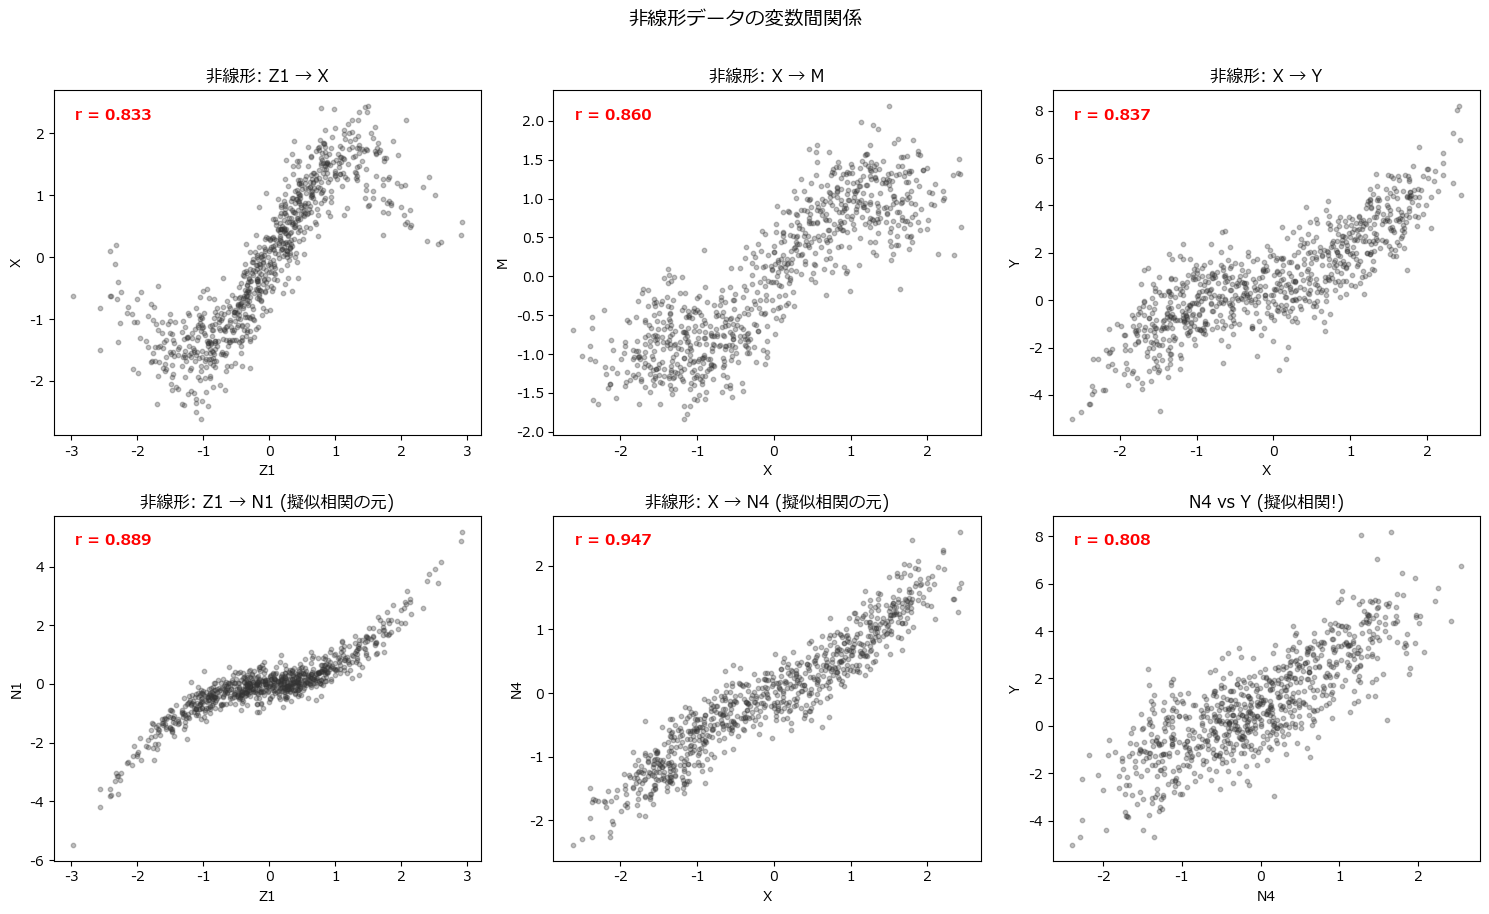


--- Y との相関係数 ---
  X    : r = +0.837  ✓ 直接原因
  M    : r = +0.679  ✓ 直接原因
  Z1   : r = +0.631  ✓ 直接原因
  D1   : r = +0.372  ✓ 直接原因
  N1   : r = +0.404  ⚠️ 擬似相関
  N4   : r = +0.808  ⚠️ 擬似相関
  N_ind: r = +0.027  (独立)


In [2]:
# === 7.1 非線形データの生成 ===
# 同じDAGトポロジだが、関数形を全て非線形にする
#
# DAG:  Z1 → X → M → Y,  Z1 → Y,  D1 → Y
#        Z1 → N1 (擬似相関),  X → N4 (擬似相関),  N_ind (独立)

rng_nl = np.random.default_rng(42)
n_nl = 800

# --- 外生変数 ---
Z1_nl = rng_nl.normal(0, 1, n_nl)
D1_nl = rng_nl.normal(0, 1, n_nl)

# --- X: Z1 からの非線形効果 ---
X_nl = np.sin(1.5 * Z1_nl) + 0.5 * Z1_nl + rng_nl.normal(0, 0.4, n_nl)

# --- M: X からの非線形効果 ---
M_nl = np.tanh(1.5 * X_nl) + rng_nl.normal(0, 0.4, n_nl)

# --- Y: 直接原因からの非線形効果 ---
Y_nl = (0.8 * X_nl**2 * np.sign(X_nl)       # X の非線形効果
        + 1.2 * np.abs(M_nl)                 # M の非線形効果
        + 0.6 * np.sin(2 * Z1_nl)            # Z1 の非線形効果
        + 0.7 * D1_nl                         # D1 の効果
        + rng_nl.normal(0, 0.5, n_nl))

# --- 擬似相関変数 (Y に因果効果なし) ---
N1_nl = 0.6 * Z1_nl**2 * np.sign(Z1_nl) + rng_nl.normal(0, 0.3, n_nl)  # Z1 の子
N4_nl = np.log(1 + X_nl**2) * np.sign(X_nl) + rng_nl.normal(0, 0.3, n_nl)  # X の子
N_ind_nl = rng_nl.normal(0, 1, n_nl)  # 独立ノイズ

df_nl = pd.DataFrame({
    'Z1': Z1_nl, 'X': X_nl, 'M': M_nl, 'D1': D1_nl,
    'Y': Y_nl, 'N1': N1_nl, 'N4': N4_nl, 'N_ind': N_ind_nl
})

NL_DIRECT = ['X', 'M', 'Z1', 'D1']
NL_SPURIOUS = ['N1', 'N4']

print('=== 非線形データセット ===')
print(f'サイズ: {df_nl.shape}')
print(f'直接原因: {NL_DIRECT}')
print(f'擬似相関: {NL_SPURIOUS}')
print(f'独立ノイズ: [N_ind]')

# 非線形関係の可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

pairs = [
    ('Z1', 'X', '非線形: Z1 → X'),
    ('X', 'M', '非線形: X → M'),
    ('X', 'Y', '非線形: X → Y'),
    ('Z1', 'N1', '非線形: Z1 → N1 (擬似相関の元)'),
    ('X', 'N4', '非線形: X → N4 (擬似相関の元)'),
    ('N4', 'Y', 'N4 vs Y (擬似相関!)'),
]

for ax, (xvar, yvar, title) in zip(axes.flatten(), pairs):
    ax.scatter(df_nl[xvar], df_nl[yvar], alpha=0.3, s=10, c='#333')
    ax.set_xlabel(xvar)
    ax.set_ylabel(yvar)
    ax.set_title(title)
    r = np.corrcoef(df_nl[xvar], df_nl[yvar])[0, 1]
    ax.annotate(f'r = {r:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
               fontsize=11, va='top', color='red', fontweight='bold')

plt.suptitle('非線形データの変数間関係', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

print('\n--- Y との相関係数 ---')
for col in ['X', 'M', 'Z1', 'D1', 'N1', 'N4', 'N_ind']:
    r = np.corrcoef(df_nl[col], df_nl['Y'])[0, 1]
    tag = '✓ 直接原因' if col in NL_DIRECT else ('⚠️ 擬似相関' if col in NL_SPURIOUS else '(独立)')
    print(f'  {col:5s}: r = {r:+.3f}  {tag}')

### 7.2 LiNGAM (線形手法) を非線形データに適用

LiNGAM は線形性を仮定しているため、非線形データでは正しく推定できないはずです。

In [3]:
import lingam

# LiNGAM を非線形データに適用
nl_cols = list(df_nl.columns)
nl_model = lingam.DirectLiNGAM()
nl_model.fit(df_nl.values)

nl_adj = nl_model.adjacency_matrix_
nl_y_idx = nl_cols.index('Y')

nl_lingam_effects = pd.Series(
    nl_adj[nl_y_idx, :], index=nl_cols
).drop('Y').sort_values(key=abs, ascending=False)

print('=== LiNGAM (線形手法) → 非線形データ ===')
print('Y への推定因果効果:')
for feat, effect in nl_lingam_effects.items():
    true_tag = ''
    if feat in NL_DIRECT:
        true_tag = ' ✓ 直接原因'
    elif feat in NL_SPURIOUS:
        true_tag = ' ⚠️ 擬似相関'
    else:
        true_tag = ' (独立ノイズ)'
    detected = '検出' if abs(effect) > 0.1 else '---'
    print(f'  {feat:5s}: {effect:+.4f}  [{detected}]{true_tag}')

print('\n--- 考察 ---')
print('LiNGAM は線形性を仮定しているため、非線形の因果効果を正しく推定できない。')
print('特に、非線形効果を持つ直接原因が過小評価される可能性がある。')
print('また、擬似相関変数にも誤って因果効果を検出する可能性がある。')

=== LiNGAM (線形手法) → 非線形データ ===
Y への推定因果効果:
  X    : +1.8835  [検出] ✓ 直接原因
  D1   : +0.7535  [検出] ✓ 直接原因
  M    : -0.4113  [検出] ✓ 直接原因
  N1   : -0.2158  [検出] ⚠️ 擬似相関
  Z1   : +0.0000  [---] ✓ 直接原因
  N4   : +0.0000  [---] ⚠️ 擬似相関
  N_ind: +0.0000  [---] (独立ノイズ)

--- 考察 ---
LiNGAM は線形性を仮定しているため、非線形の因果効果を正しく推定できない。
特に、非線形効果を持つ直接原因が過小評価される可能性がある。
また、擬似相関変数にも誤って因果効果を検出する可能性がある。


### 7.3 カーネル条件付き独立性検定 (KCI) による擬似相関の判別

KCI (Kernel Conditional Independence) テストは、カーネル法を用いて
**非線形な条件付き独立性** を検定できます。

擬似相関の判別ロジック:
- `N4 ⊥ Y | X` が成立 → N4 は X を条件付けると Y と独立 → **擬似相関**
- `X ⊥ Y | {M, Z1, D1}` が不成立 → X は他を条件付けても Y と独立でない → **直接原因**

この性質は DAG の d-分離に基づくため、関数形（線形・非線形）に依存しません。

In [4]:
from causallearn.utils.cit import CIT

# KCI (カーネル条件付き独立性) 検定
# 計算量を抑えるため、サブサンプルを使用
n_sub = 400
rng_sub = np.random.default_rng(42)
idx_sub = rng_sub.choice(n_nl, n_sub, replace=False)
data_nl = df_nl.values[idx_sub]

kci_test = CIT(data_nl, method='kci')

# カラムのインデックスを取得
col_idx = {col: i for i, col in enumerate(nl_cols)}

print('=== KCI 条件付き独立性検定 (非線形対応) ===')
print(f'サンプル数: {n_sub} (計算量削減のためサブサンプル)\n')

# --- 擬似相関の検定 ---
# H0: 変数 X と Y は条件付き集合 S のもとで独立
# p > 0.05 → 独立 (擬似相関)、p < 0.05 → 非独立 (直接関係あり)

tests = [
    ('N4', 'Y', ['X'],           '独立 (擬似相関)',   'N4 ⊥ Y | X   : N4 は X の子 → X で条件付けると Y と独立'),
    ('N1', 'Y', ['Z1'],          '独立 (擬似相関)',   'N1 ⊥ Y | Z1  : N1 は Z1 の子 → Z1 で条件付けると Y と独立'),
    ('N_ind', 'Y', [],           '独立 (無関係)',     'N_ind ⊥ Y    : 独立ノイズ → Y と無関係'),
    ('X', 'Y', ['M', 'Z1', 'D1'], '非独立 (直接原因)', 'X ⊥ Y | M,Z1,D1 : X は Y の直接原因 → 条件付けても非独立'),
    ('D1', 'Y', ['X', 'M', 'Z1'], '非独立 (直接原因)', 'D1 ⊥ Y | X,M,Z1 : D1 は Y の直接原因 → 条件付けても非独立'),
    ('N4', 'Y', [],              '非独立 (周辺相関)',  'N4 ⊥ Y       : 条件付けなし → 擬似相関で非独立に見える'),
]

results = []
for var1, var2, cond_set, expected, desc in tests:
    cond_idx = [col_idx[c] for c in cond_set]
    p_val = kci_test(col_idx[var1], col_idx[var2], cond_idx)
    is_indep = p_val > 0.05
    verdict = '独立' if is_indep else '非独立'
    match = '✓' if (('独立' in expected and is_indep) or ('非独立' in expected and not is_indep)) else '✗'
    results.append({
        'test': desc.split(':')[0].strip(),
        'p_value': p_val,
        'verdict': verdict,
        'expected': expected,
        'match': match,
    })
    print(f'{match} {desc}')
    print(f'    p = {p_val:.4f} → {verdict} (期待: {expected})\n')

print('=' * 60)
n_correct = sum(1 for r in results if r['match'] == '✓')
print(f'正解率: {n_correct}/{len(results)}')
print(f'\n→ KCI 検定は非線形データでも擬似相関を正しく判別できる！')

=== KCI 条件付き独立性検定 (非線形対応) ===
サンプル数: 400 (計算量削減のためサブサンプル)

✓ N4 ⊥ Y | X   : N4 は X の子 → X で条件付けると Y と独立
    p = 0.6518 → 独立 (期待: 独立 (擬似相関))



✓ N1 ⊥ Y | Z1  : N1 は Z1 の子 → Z1 で条件付けると Y と独立
    p = 0.3004 → 独立 (期待: 独立 (擬似相関))

✓ N_ind ⊥ Y    : 独立ノイズ → Y と無関係
    p = 0.2867 → 独立 (期待: 独立 (無関係))



✓ X ⊥ Y | M,Z1,D1 : X は Y の直接原因 → 条件付けても非独立
    p = 0.0000 → 非独立 (期待: 非独立 (直接原因))

✓ D1 ⊥ Y | X,M,Z1 : D1 は Y の直接原因 → 条件付けても非独立
    p = 0.0000 → 非独立 (期待: 非独立 (直接原因))



✓ N4 ⊥ Y       : 条件付けなし → 擬似相関で非独立に見える
    p = 0.0000 → 非独立 (期待: 非独立 (周辺相関))

正解率: 6/6

→ KCI 検定は非線形データでも擬似相関を正しく判別できる！


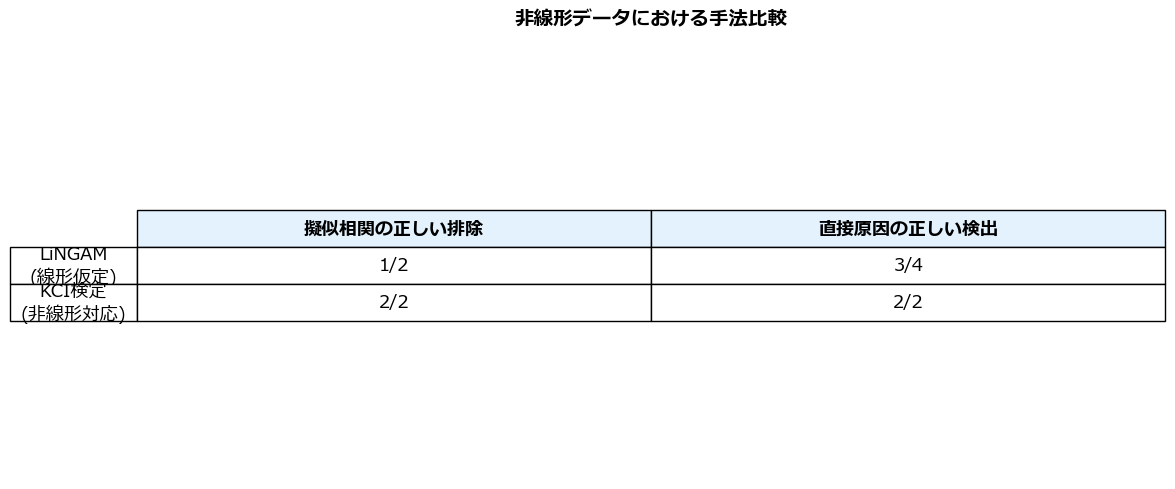

=== 非線形データでの検証まとめ ===

1. LiNGAM (線形仮定):
   - 擬似相関として誤検出: ['N1']
   - 検出できなかった直接原因: ['Z1']
   → 線形仮定が崩れると、擬似相関と直接原因の区別が不正確になる

2. KCI 条件付き独立性検定 (非線形対応):
   - 正解率: 6/6
   → 条件付き独立性は DAG の性質なので、非線形でも正しく判別可能

結論: 非線形関係でも「擬似相関かどうか」の判別は可能。
ただし、適切な非線形対応の検定手法 (KCI等) を使う必要がある。


In [5]:
# === 7.4 手法比較まとめ: 非線形データでの擬似相関判別 ===

# LiNGAM の結果
lingam_detected_spurious_as_cause = [
    feat for feat in NL_SPURIOUS if abs(nl_lingam_effects[feat]) > 0.1
]
lingam_missed_direct = [
    feat for feat in NL_DIRECT if abs(nl_lingam_effects[feat]) < 0.1
]

# KCI の結果
kci_results_for_plot = pd.DataFrame(results)

fig, ax = plt.subplots(figsize=(12, 5))

summary_data = {
    '手法': ['LiNGAM\n(線形仮定)', 'KCI検定\n(非線形対応)'],
    '擬似相関の\n正しい排除': [
        f'{len(NL_SPURIOUS) - len(lingam_detected_spurious_as_cause)}/{len(NL_SPURIOUS)}',
        f'{sum(1 for r in results[:2] if r["match"]=="✓")}/2'
    ],
    '直接原因の\n正しい検出': [
        f'{len(NL_DIRECT) - len(lingam_missed_direct)}/{len(NL_DIRECT)}',
        f'{sum(1 for r in results[3:5] if r["match"]=="✓")}/2'
    ],
}

ax.axis('off')
table = ax.table(
    cellText=[[summary_data['擬似相関の\n正しい排除'][i],
               summary_data['直接原因の\n正しい検出'][i]]
              for i in range(2)],
    rowLabels=summary_data['手法'],
    colLabels=['擬似相関の正しい排除', '直接原因の正しい検出'],
    cellLoc='center',
    rowLoc='center',
    loc='center',
)
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1.2, 2.0)

for j in range(2):
    table[0, j].set_facecolor('#E3F2FD')
    table[0, j].set_text_props(fontweight='bold')

ax.set_title('非線形データにおける手法比較', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('=== 非線形データでの検証まとめ ===')
print()
print('1. LiNGAM (線形仮定):')
print(f'   - 擬似相関として誤検出: {lingam_detected_spurious_as_cause}')
print(f'   - 検出できなかった直接原因: {lingam_missed_direct}')
print(f'   → 線形仮定が崩れると、擬似相関と直接原因の区別が不正確になる')
print()
print('2. KCI 条件付き独立性検定 (非線形対応):')
print(f'   - 正解率: {n_correct}/{len(results)}')
print(f'   → 条件付き独立性は DAG の性質なので、非線形でも正しく判別可能')
print()
print('結論: 非線形関係でも「擬似相関かどうか」の判別は可能。')
print('ただし、適切な非線形対応の検定手法 (KCI等) を使う必要がある。')

---
次のノートブック: [05_summary.ipynb](05_summary.ipynb) で全体のまとめと使い分けガイドラインを確認します。